# ATLAS Deep Learning with Keras

Currently this notebook is for testing an ML workflow on the ATLAS RPV analysis which uses calorimeter cluster images. I am working with Keras.

In [ ]:
from __future__ import print_function
import numpy as np
from keras import layers, models

import matplotlib.pyplot as plt
%matplotlib notebook

Using Theano backend.


## Load some data

Let's just pick a couple of files to play with at the start.

In [ ]:
sig_file = '/project/projectdirs/atlas/sfarrell/atlas_dl/numpy/dev/GG_RPV10_1000_250.npz'
bkg_file = '/project/projectdirs/atlas/sfarrell/atlas_dl/numpy/dev/jetjet_JZ5.npz'

In [ ]:
class DataObj():
    pass

def load_file(filename, num_event=None):
    data = DataObj()
    with np.load(filename) as f:
        data.histos = f['histos'][:num_event]
        data.weights = f['weights'][:num_event]
        data.passSR = f['passSR'][:num_event]
    return data

sig = load_file(sig_file, 20000)
bkg = load_file(bkg_file, 20000)

assert(bkg.histos.shape[1:] == sig.histos.shape[1:])
image_size = bkg.histos.shape[1]

## Data processing

In [ ]:
def split_train_val(x, y, train_frac=0.8):
    inds = np.arange(x.shape[0])
    # split train, val, test
    tr_inds = inds[:int(train_frac*len(inds))] 
    val_inds = inds[int(train_frac*len(inds)):]

    x_tr, y_tr, x_val, y_val = x[tr_inds], y[tr_inds], x[val_inds], y[val_inds]
    return x_tr, y_tr, x_val, y_val

def preprocess(x, max_abs=None):
    '''a type of sparse preprocessing, which scales everything between -1 and 1 without losing sparsity'''
    #only calculate the statistic using training set
    if max_abs is None:
        max_abs=np.abs(x).max(axis=(0,1,2,3))

    #then scale all sets
    x /= max_abs
    print(np.max(x))
    print(np.min(x))
    return x, max_abs

def shuffle(*a):
    inds = np.arange(a[0].shape[0])
    rng = np.random.RandomState(7)
    rng.shuffle(inds)
    return map(lambda x: x[inds], a)

In [ ]:
# Concatenate signal and background and reshape to [N, channels, height, width]
data = np.concatenate([sig.histos.reshape(sig.histos.shape[0], 1, image_size, image_size),
                       bkg.histos.reshape(bkg.histos.shape[0], 1, image_size, image_size)])
labels = np.concatenate([np.ones(sig.histos.shape[0]), np.zeros(bkg.histos.shape[0])])
passSR = np.concatenate([sig.passSR, bkg.passSR])
# Shuffle data
data, labels, passSR = shuffle(data, labels, passSR)
# Split into training and test set
train_data, train_labels, test_data, test_labels = split_train_val(data, labels)

print('Training data:', train_data.shape)
print('Test data:    ', test_data.shape)

## Summarize the data 

In [71]:
# Plot helper function
def plot_calo_image(h2d):
    """Plot a calo-image on the current axes"""
    plt.imshow(np.log10(h2d).T, extent=[-2.5, 2.5, -3.15, 3.15],
               interpolation='none', aspect='auto', origin='low')
    plt.colorbar(label='Cluster energy [Log(MeV)]')
    plt.xlabel('eta')
    plt.ylabel('phi')

<IPython.core.display.Javascript object>


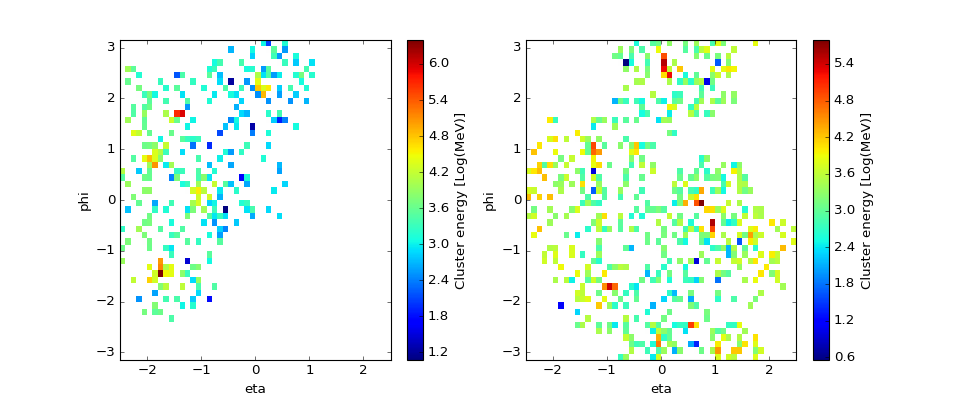

In [72]:
# Draw a couple of calo images
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_calo_image(bkg.histos[0])
plt.subplot(122)
plot_calo_image(sig.histos[0])

In [73]:
num_bkg, num_sig = bkg.weights.size, sig.weights.size
num_bkg_passSR = np.sum(bkg.passSR)
num_sig_passSR = np.sum(sig.passSR)

bkg_rejection = float(num_bkg - num_bkg_passSR) / num_bkg
sig_efficiency = float(num_sig_passSR) / num_sig

# Print some summary information
print('Background events')
print('  Total: ', bkg.weights.size)
print('  Weighted total: %g' % np.sum(bkg.weights))
print('  PassSR:', num_bkg_passSR)
print('  Bkg rejection:', bkg_rejection)
print('Signal events')
print('  Total: ', sig.weights.size)
print('  Weighted total: %g' % np.sum(sig.weights))
print('  PassSR:', num_sig_passSR)
print('  Sig efficiency:', sig_efficiency)

print('\nTotal SR accuracy:', float(num_sig_passSR + bkg.weights.size - num_bkg_passSR) /
                           (sig.weights.size + bkg.weights.size))

Background events
  Total:  20000
  Weighted total: 23910.4
  PassSR: 8
  Bkg rejection: 0.9996
Signal events
  Total:  20000
  Weighted total: 7.80931
  PassSR: 714
  Sig efficiency: 0.0357

Total SR accuracy: 0.51765


## Define some models

Start with a simple fully-connected NN. Then try a deep fully-connected NN. Then try a CNN.

In [74]:
def build_simple_model(image_size, other_metrics=[]):
    """Construct the simple Keras model which is basically just logistic regression"""
    model = models.Sequential([
        layers.Dense(1, input_dim=image_size*image_size, activation='sigmoid')
    ])
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'] + other_metrics)
    return model

def build_dnn_model(image_size, other_metrics=[]):
    """Construct the Keras model"""
    model = models.Sequential([
        layers.Dense(100, input_dim=image_size*image_size, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'] + other_metrics)
    return model

def build_cnn_model(image_size, other_metrics=[]):
    """Construct a convolutional model"""
    model = models.Sequential([
        layers.Convolution2D(10, 10, 10, input_shape=(1, image_size, image_size),
                             activation='relu', dim_ordering='th'),
        #layers.Convolution2D(10, 5, 5, activation='relu'),
        layers.MaxPooling2D(pool_size=(5, 5)),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'] + other_metrics)
    return model

## Training

In [75]:
def evaluate_model(y_true, y_pred):
    """Print metrics for bkg rejection and signal efficiency"""
    # Round prediction scores into integers
    correct = np.rint(y_pred) == y_true
    sig_eff = np.mean(correct[y_true==1])
    bkg_rej = np.mean(correct[y_true==0])
    return {'sig_eff': sig_eff, 'bkg_rej': bkg_rej}

In [76]:
# Evaluate the analysis SR
passSR = np.concatenate([sig.passSR, bkg.passSR])
train_passSR, _, test_passSR, _ = split_train_val(passSR, labels)
print('Training set:', evaluate_model(train_labels, train_passSR))
print('Test set:    ', evaluate_model(test_labels, test_passSR))

Training set: {'sig_eff': 0.02362155388471178, 'bkg_rej': 0.97849127182044893}
Test set:     {'sig_eff': 0.0, 'bkg_rej': 1.0}


### Train the dense models

In [77]:
# Need to flatten the data first
train_data_flat = train_data.reshape(train_data.shape[0], -1)
test_data_flat = test_data.reshape(test_data.shape[0], -1)
print('Training data:', train_data_flat.shape)
print('Test data:    ', test_data_flat.shape)

Training data: (32000, 2500)
Test data:     (8000, 2500)


In [ ]:
model1 = build_simple_model(image_size)
model1.summary()
model1.fit(train_data_flat, train_labels, batch_size=1000, nb_epoch=10, shuffle=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_17 (Dense)                 (None, 1)             2501        dense_input_8[0][0]              
Total params: 2501
____________________________________________________________________________________________________
Epoch 1/10
32000/32000 [==============================] - 0s - loss: 8.1010 - acc: 0.4952     
Epoch 2/10
32000/32000 [==============================] - 0s - loss: 8.2495 - acc: 0.4865     
Epoch 3/10
32000/32000 [==============================] - 0s - loss: 8.1850 - acc: 0.4910     
Epoch 4/10
32000/32000 [==============================] - 0s - loss: 8.1548 - acc: 0.4931     
Epoch 5/10
32000/32000 [==============================] - 0s - loss: 8.1548 - acc: 0.4931     
Epoch 6/10
16000/32000 [==============>...............] - ETA: 0s - loss: 8.1126 - acc: 0.4958

In [67]:
# Evaluate the model
train1_preds = model1.predict(train_data_flat)
print('Training set:', evaluate_model(train_labels, train1_preds))
test1_preds = model1.predict(test_data_flat)
print('Test set:', evaluate_model(test_labels, test1_preds))

Training set: {'sig_eff': 0.59631250000000002, 'bkg_rej': 0.58691666666666664}
Test set: {'sig_eff': nan, 'bkg_rej': 0.15162500000000001}


In [52]:
model2 = build_dnn_model(image_size)
model2.summary()
model2.fit(train_data_flat, train_labels, batch_size=500, nb_epoch=10)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_10 (Dense)                 (None, 100)           250100      dense_input_6[0][0]              
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 10)            1010        dense_10[0][0]                   
____________________________________________________________________________________________________
dense_12 (Dense)                 (None, 10)            110         dense_11[0][0]                   
____________________________________________________________________________________________________
dense_13 (Dense)                 (None, 10)            110         dense_12[0][0]                   
___________________________________________________________________________________________

In [53]:
# Evaluate the model
train2_preds = model2.predict(train_data_flat)
print('Training set:', evaluate_model(train_labels, train2_preds))
test2_preds = model2.predict(test_data_flat)
print('Test set:', evaluate_model(test_labels, test2_preds))

Training set: {'sig_eff': 0.625, 'bkg_rej': 0.625}
Test set: {'sig_eff': nan, 'bkg_rej': 0.0}


### Train the CNN model

In [61]:
model3 = build_cnn_model(image_size)
model3.summary()
model3.fit(train_data, train_labels, batch_size=100, nb_epoch=2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 10, 41, 41)    1010        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 10, 8, 8)      0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 640)           0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
dense_15 (Dense)                 (None, 1)             641         flatten_1[0][0]                  
Total params: 1651
________________________________________________________________________

In [62]:
# Evaluate the model
train3_preds = model3.predict(train_data)
print('Training set:', evaluate_model(train_labels, train3_preds))
test3_preds = model3.predict(test_data)
print('Test set:', evaluate_model(test_labels, test3_preds))

Training set: {'sig_eff': 0.62498750000000003, 'bkg_rej': 0.62485416666666671}
Test set: {'sig_eff': nan, 'bkg_rej': 0.00025000000000000001}
